In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.impute import SimpleImputer
from category_encoders import OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge  # noqa F401
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.utils.validation import check_is_fitted
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [53]:
df = pd.read_csv("data/mexico-city-real-estate.csv")

In [54]:
df.head()

,property_type,price_aprox_usd,surface_covered_in_m2,lat,lon,state
0,apartment,289775.66,54.0,23.634501,-102.552788,Distrito Federal
1,apartment,48822.82,100.0,19.279771,-99.234597,Distrito Federal
2,apartment,337720.36,135.0,23.634501,-102.552788,Distrito Federal
3,apartment,232663.51,87.0,19.432657,-99.177444,Distrito Federal
4,apartment,166001.78,100.0,19.367025,-99.170349,Distrito Federal


In [55]:
df["state"].value_counts()

Distrito Federal    13173
Quintana Roo         2355
Name: state, dtype: int64

In [56]:
# Plot Mapbox location and price
fig = px.scatter_mapbox(
    df,
    lat="lat",
    lon="lon",
    width=1000,
    height=800,
    center={"lat": 19.43,"lon": -99.13},
    color="price_aprox_usd",
    hover_data=["price_aprox_usd"],  # Display price when hovering mouse over house
)
fig.update_layout(mapbox_style="open-street-map")

fig.show()

### Split

In [57]:
# Split data into feature matrix "X_train" and target vector "y_train"
target = "price_aprox_usd"
features = ["property_type", "surface_covered_in_m2", "lat", "lon", "state"]
X = df[features]
y = df[target]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Build Model
#### Baseline

In [58]:
y_mean = y_train.mean()
y_pred_baseline = [y_mean] * len(y_train)
baseline_mae = mean_absolute_error(y_train, y_pred_baseline)
print("Mean price:", round(y_mean, 2))
print("Baseline MAE:", round(baseline_mae, 2))

Mean price: 194570.98
Baseline MAE: 139987.56


In [59]:
# Build Model
model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    Ridge()
)

# Fit model
model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['property_type', 'state'],
                               use_cat_names=True)),
                ('simpleimputer', SimpleImputer()), ('ridge', Ridge())])

### Evaluate

In [60]:
# Make predictions on the test data
y_test_pred = model.predict(X_test)

# Calculate the MAE of the test data
mae_test = mean_absolute_error(y_test, y_test_pred)

print("Mean Absolute Error (Test Data):", round(mae_test, 2))

Mean Absolute Error (Test Data): 100650.25


### Communicate Results

In [62]:
coefficients = model.named_steps["ridge"].coef_
features = model.named_steps["onehotencoder"].get_feature_names()
feat_imp = pd.Series(coefficients, index=features)
feat_imp.abs().sort_values()

surface_covered_in_m2        1707.718899
lat                         11175.963554
lon                         34889.717067
property_type_apartment     46310.036200
property_type_store         53111.423046
property_type_house         99421.459245
state_Distrito Federal     234023.469375
state_Quintana Roo         234023.469376
dtype: float64

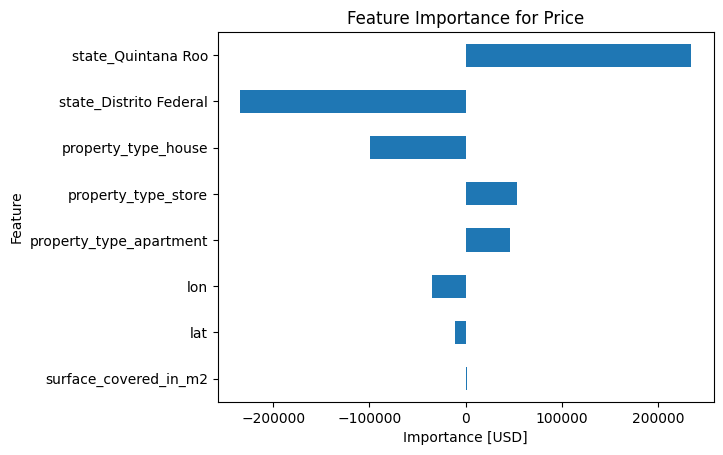

In [64]:
# Build bar chart
feat_imp.sort_values(key=abs).plot(kind="barh")
# Label axes
plt.xlabel("Importance [USD]")
plt.ylabel("Feature")

# Add title
plt.title("Feature Importance for Price");